In [128]:
import gpytorch
import matplotlib.pyplot as plt
import torch
from torch import nn

from func_algorithms import *
from func_data_generation import *
from func_polygon import *
from utils import *
from warp_units import *

# from torchsummary import summary


dtype = torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
# device =  "cpu"
print("Using {} device".format(device))

import tqdm

torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

Using cuda device
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
class WarpModel(torch.nn.Sequential):
    def __init__(self):
        super(WarpModel, self).__init__()
        self.add_module(
            "axial_dim0", AxialWarpUnit(dim=0, res=50, grad=20, lims=[0, 1.0])
        )
        self.add_module(
            "axial_dim1", AxialWarpUnit(dim=1, res=50, grad=20, lims=[-1.0, 0])
        )
        self.add_module("rbf_seq1", rbfunit_sequential(res=2, ylim=[-1.0, 0.0]))
        self.add_module("rbf_seq2", rbfunit_sequential(res=3, ylim=[-1, 0]))
        self.add_module("mobius", MobiusWarpUnit())


class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, warp_model):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        #             self.covar_module = gpytorch.kernels.GridInterpolationKernel(
        #                 gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
        #                 num_dims=2, grid_size=100
        #             )
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #         self.covar_module = gpytorch.kernels.SpectralMixtureKernel(
        #             num_mixtures=4, ard_num_dims=2
        #         )
        #         self.covar_module2 = gpytorch.kernels.ScaleKernel(
        #             gpytorch.kernels.PolynomialKernel(1, active_dimes=[0])
        #             * gpytorch.kernels.PolynomialKernel(1, active_dimes=[1])
        #         )
        #         self.covar_module2 = gpytorch.kernels.ScaleKernel(
        #             gpytorch.kernels.PolynomialKernel(power=2)
        #         )
        self.covar_module2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.space_transform = warp_model

        #         self.register_parameter(
        #             name="offset", parameter=torch.nn.Parameter(torch.zeros(1, 2))
        #         )

    def forward(self, x):
        # We're first putting our data through a deep net (feature extractor)
        # We're also scaling the features so that they're nice values
        projected_x = self.space_transform(x)
        projected_x = projected_x - projected_x.min(0)[0]
        projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(projected_x) + self.covar_module2(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [130]:
data_num = 4
sensor_num = 200  # [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# load data
data_filename = DATA_PATH + "/datasets_" + str(data_num) + ".hd5f"

if os.path.exists(data_filename):
    with h5py.File(data_filename, "r") as f1:
        coords = f1["coords"][...]
        true_rss = f1["true_rss"][...]
        observed_rss = f1["observed_rss"][...]
        train_X = f1["train_" + str(sensor_num) + "/train_X"][...]
        train_y = f1["train_" + str(sensor_num) + "/train_y"][...]
        idx = f1["train_" + str(sensor_num) + "/idx"][...]

In [131]:
# Normalize train_X to 0-1
data_X_tensor = torch.from_numpy(train_X).to(device) / 1000
coords_tensor = torch.from_numpy(coords).to(device) / 1000

train_y_tensor = torch.from_numpy(train_y).to(device)
train_y_mean = train_y_tensor.mean()
data_y_tensor = train_y_tensor - train_y_mean
# train_y_sigma = torch.sqrt(train_y_tensor.var())
# train_y_tensor = (train_y_tensor - train_y_mean) / train_y_sigma

In [132]:
train_num = int(sensor_num * 0.9)
train_X_tensor = data_X_tensor[0:train_num, :]
train_y_tensor = data_y_tensor[0:train_num]
test_X_tensor = data_X_tensor[train_num:, :]
test_y_tensor = data_y_tensor[train_num:]

In [133]:
# Define and initialize model
warp_model = WarpModel().to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
gp_model = GPRegressionModel(
    train_x=train_X_tensor,
    train_y=train_y_tensor,
    likelihood=likelihood,
    warp_model=warp_model,
).to(device)
# gp_model.likelihood.noise = 0.2

In [134]:
checkpoint = torch.load("checkpoint.dat")

In [135]:
gp_model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

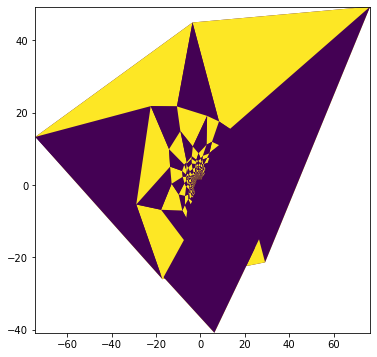

In [136]:
chessboard_from_model(warp_model)

In [137]:
likelihood.eval()
gp_model.eval()
# gp_model.w1 = 1
# gp_model.w2 = 1
observed_pred = gp_model(coords_tensor)
mean = observed_pred.mean.detach() + train_y_mean
var = observed_pred.variance.detach()

/home/nicegeek/miniconda3/envs/GPTor_cuda/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


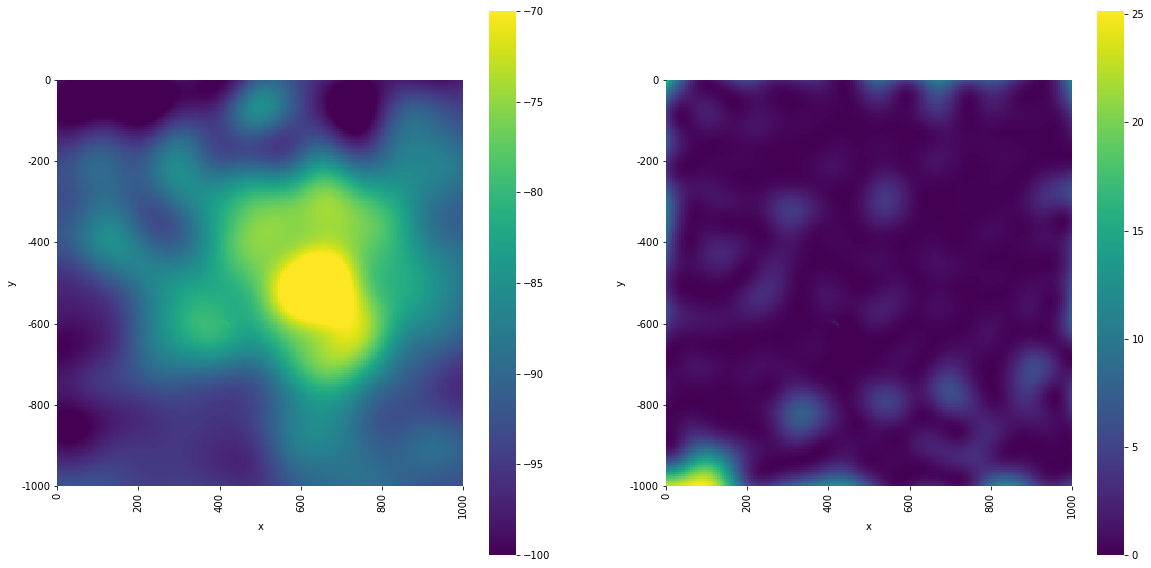

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_heatmap(coords, mean, ax=axes[0], vmin=-100, vmax=-70, cbar=True)
# plot_heatmap(coords, mean, ax=axes[0], vmin=-103, vmax=-63, cbar=True)
plot_heatmap(coords, var, ax=axes[1], cbar=True)

In [139]:
save_result("result_4", "warpgp", sensor_num, mean.cpu().numpy(), var.cpu().numpy())